In [52]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
import robust_loss_pytorch.general

# Construct some regression data with some extreme outliers.
np.random.seed(1)
n = 50
scale_true = 0.7
shift_true = 0.15
x = np.random.uniform(size=n)
y = scale_true * x + shift_true
y += np.random.normal(scale=0.025, size=n)
flip_mask = np.random.uniform(size=n) > 0.9
y = np.where(flip_mask, 0.05 + 0.4 * (1. - np.sign(y - 0.5)), y)

x = torch.Tensor(x)
y = torch.Tensor(y)

class RegressionModel(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(RegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(2, 1)
    def forward(self, x): 
        x = torch.cat([(x**2).view(-1,1), x.view(-1,1)], axis=1)
        return self.linear(x)[:,0]

def plot_regression(regression):
    # A helper function for plotting a regression module.
    x_plot = np.linspace(0, 1, 100)
    y_plot = regression(torch.Tensor(x_plot)).detach().numpy()
    y_plot_true = x_plot * scale_true + shift_true

    plt.figure(0, figsize=(4,4))
    plt.scatter(x, y)
    plt.plot(x_plot, y_plot_true, color='k')
    plt.plot(x_plot, y_plot, color='r')

0   : loss=47.855762
100 : loss=2.942661
200 : loss=1.935564
300 : loss=1.708241
400 : loss=1.680003
500 : loss=1.676927
600 : loss=1.675559
700 : loss=1.674234
800 : loss=1.672914
900 : loss=1.671623
1000: loss=1.670378
1100: loss=1.669198
1200: loss=1.668096
1300: loss=1.667082
1400: loss=1.666161
1500: loss=1.665337
1600: loss=1.664609
1700: loss=1.663976
1800: loss=1.663434
1900: loss=1.662975


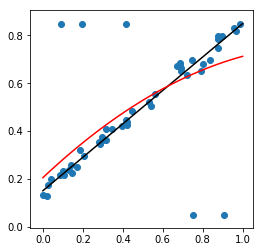

In [53]:
# Fit a linear regression using mean squared error.
regression = RegressionModel() 
params = regression.parameters()
optimizer = torch.optim.Adam(params, lr = 0.01) 

for epoch in range(2000): 

    y_i = regression(x) 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y_i - y, alpha=torch.Tensor([2.]), scale=torch.Tensor([0.1])))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 100) == 0:
        print('{:<4}: loss={:03f}'.format(epoch, loss.data)) 

# It doesn't fit well.
plot_regression(regression)

0   : loss=1.556993  alpha=1.004995  scale=0.993690
100 : loss=0.335633  alpha=1.458809  scale=0.424481
200 : loss=-0.268484  alpha=1.671784  scale=0.184369
300 : loss=-0.421721  alpha=1.475862  scale=0.129781
400 : loss=-0.724386  alpha=0.808925  scale=0.077851
500 : loss=-1.212487  alpha=0.294854  scale=0.032794
600 : loss=-1.435970  alpha=0.128024  scale=0.017800
700 : loss=-1.490586  alpha=0.074326  scale=0.014142
800 : loss=-1.503530  alpha=0.051739  scale=0.013106
900 : loss=-1.509155  alpha=0.039771  scale=0.012708
1000: loss=-1.512253  alpha=0.032359  scale=0.012514
1100: loss=-1.513582  alpha=0.027280  scale=0.012394
1200: loss=-1.515570  alpha=0.023561  scale=0.012308
1300: loss=-1.516553  alpha=0.020705  scale=0.012254
1400: loss=-1.517309  alpha=0.018437  scale=0.012199
1500: loss=-1.517887  alpha=0.016587  scale=0.012166
1600: loss=-1.518374  alpha=0.015046  scale=0.012131
1700: loss=-1.518757  alpha=0.013743  scale=0.012111
1800: loss=-1.519094  alpha=0.012624  scale=0.01

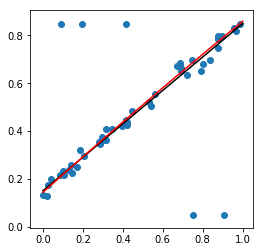

In [54]:
# Fit a linear regression, and the parameters of an adaptive loss.
regression = RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu')
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 

for epoch in range(2000): 

    y_i = regression(x) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 100) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 

# It fits!
plot_regression(regression)

In [50]:
regression(x)

tensor([0.4468, 0.6637, 0.1487, 0.3648, 0.2536, 0.2147, 0.2818, 0.3957, 0.4323,
        0.5339, 0.4484, 0.6386, 0.2948, 0.7765, 0.1682, 0.6280, 0.4470, 0.5481,
        0.2490, 0.2903, 0.7212, 0.8410, 0.3728, 0.6437, 0.7753, 0.7883, 0.2095,
        0.1766, 0.2701, 0.7765, 0.2190, 0.4498, 0.8336, 0.5299, 0.6434, 0.3743,
        0.6395, 0.7454, 0.1617, 0.6850, 0.8557, 0.6836, 0.3492, 0.7130, 0.2225,
        0.4689, 0.7983, 0.3586, 0.3544, 0.2416], grad_fn=<SelectBackward>)

In [51]:
x[:, None]

tensor([[4.1702e-01],
        [7.2032e-01],
        [1.1437e-04],
        [3.0233e-01],
        [1.4676e-01],
        [9.2339e-02],
        [1.8626e-01],
        [3.4556e-01],
        [3.9677e-01],
        [5.3882e-01],
        [4.1919e-01],
        [6.8522e-01],
        [2.0445e-01],
        [8.7812e-01],
        [2.7388e-02],
        [6.7047e-01],
        [4.1730e-01],
        [5.5869e-01],
        [1.4039e-01],
        [1.9810e-01],
        [8.0074e-01],
        [9.6826e-01],
        [3.1342e-01],
        [6.9232e-01],
        [8.7639e-01],
        [8.9461e-01],
        [8.5044e-02],
        [3.9055e-02],
        [1.6983e-01],
        [8.7814e-01],
        [9.8347e-02],
        [4.2111e-01],
        [9.5789e-01],
        [5.3317e-01],
        [6.9188e-01],
        [3.1552e-01],
        [6.8650e-01],
        [8.3463e-01],
        [1.8288e-02],
        [7.5014e-01],
        [9.8886e-01],
        [7.4817e-01],
        [2.8044e-01],
        [7.8928e-01],
        [1.0323e-01],
        [4